# Faraday Rotation
## Result analyser

To Plot ZDF data files you must first import the ZDF module

In [1]:
import numpy as np
import nb_hlpr.tooler as tooler
import nb_hlpr.widg as widg
import nb_hlpr.visual as visual
from IPython.display import HTML

First you need to select the data files that correspond to your simulation using the file chooser below.
<br> You may also specify the data type (*e.g* "charge")

You can also choose to plot a single quantity or two at the same time on the "Settings" tab.



In [2]:
tab=widg.tabmaker()
tab

### Visualization

Here you can use the slider to advance or go backwards in time

In [13]:
ylims=[[0,0],[0,0]]
fils=[]

widg.shower(tab,ylims,fils)[0]

<function nb_hlpr.visual.pltinteract.<locals>.pltstf>

You may also produce a video

In [30]:
anim=visual.animate(tab,ylims)

#HTML(anim.to_html5_video())

And save it using a name of your choice, choose wisely as it can't be changed later

In [31]:
anim.save("aaprob.mp4",fps=30)

In [29]:
def func(t,A,w,l):
    return A*np.cos(w*t-l)**2

In [58]:
from scipy.optimize import curve_fit
files=visual.filer(tab)

lstft=np.abs(scipy.fftpack.fft(read_grid(files[0][0])[0]))
info=read_grid(files[0][-1])[1]
tf=info['iteration']['t']

tl=np.linspace(0,tf,len(files[0]))

maxit=list(lstft).index(max(lstft))


maxlst=[np.abs(scipy.fftpack.fft(read_grid(fil)[0]))[maxit]**2 for fil in files[0]]
maxlst2=[np.abs(scipy.fftpack.fft(read_grid(fil)[0]))[maxit]**2 for fil in files[1]]


popt, pcov = curve_fit(func, tl,maxlst,p0=[max(maxlst),0.015,-1.5])
plt.plot(tl, func(tl, *popt), 'r-', label='fit')

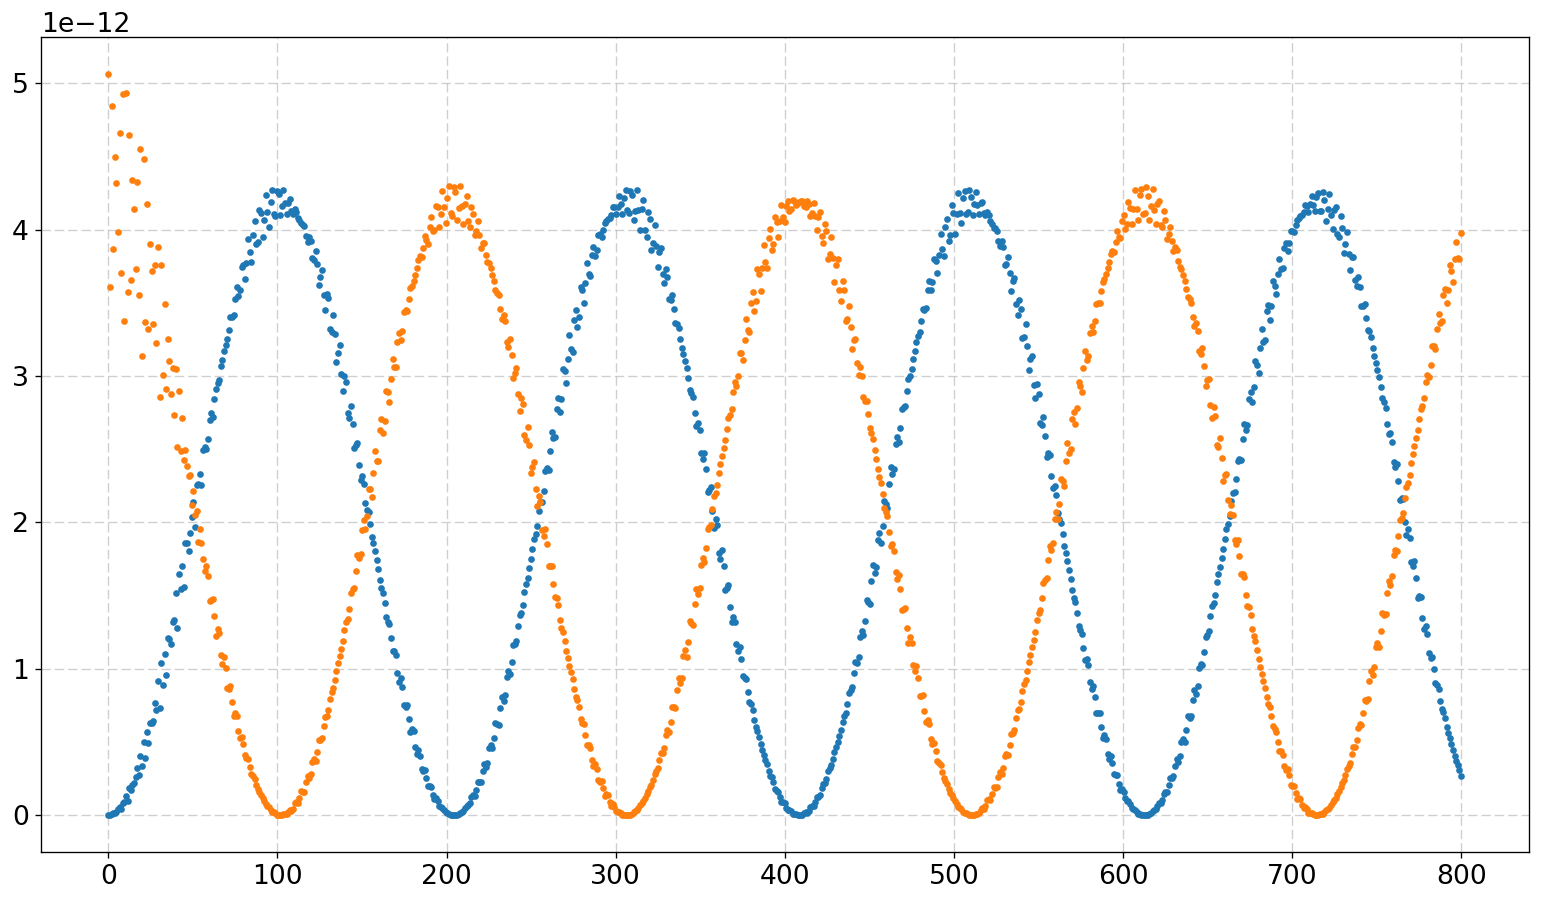

In [73]:
fig=plt.figure(figsize=(16, 9), dpi= 120, facecolor='w', edgecolor='k');
matplotlib.rcParams.update({'font.size': 16})
plt.grid(alpha=0.6,linestyle='dashed')
plt.plot(tl,maxlst,'.')
plt.plot(tl,maxlst2,'.')
plt.show()

In [93]:
def animmu(tl,y1,y2):
    minx=tl[0]
    maxx=tl[-1]

    minv=min([min(y1),min(y2)])
    maxv=max([max(y1),max(y2)])
    
    lines=[]
    fig2=plt.figure(figsize=(16, 9), dpi= 120, facecolor='w', edgecolor='k');
    plt.grid(alpha=0.6,linestyle='dashed')

    ax1=plt.subplot(1,1,1);
    lines.append([])
    lines[0].append(ax1.plot([],[],c="orangered",label="$|E_3|^2$")[0]);
    lines[0].append(ax1.plot([],[],'o',c="darkred")[0]);
    lines[0].append(ax1.plot([],[],c="darkred")[0]);
    
    #ax1.set_xlim(0,9)
    #ax1.set_ylim(0,20)
    
    ax1.yaxis.get_major_formatter().set_powerlimits((0, 1))
    ax1.set_ylabel("m$^2$s$^{-2}$")
    ax1.set_xlabel("$x$(cm)")

    ax1.set_xlim([minx-(maxx-minx)/20, maxx+(maxx-minx)/20])
    ax1.set_ylim([minv-(maxv-minv)/20, maxv+(maxv-minv)/20])
    
    lines.append([])
    lines[1].append(ax1.plot([],[],c="dodgerblue",label="$|E_2|^2$")[0]);
    lines[1].append(ax1.plot([],[],'o',c="royalblue")[0]);
    lines[1].append(ax1.plot([],[],c="royalblue")[0]);
    ax1.set_xlabel("$ t$ [$1/\omega_p$]")
    ax1.set_ylabel("[$|m_ec\omega_{pe}^{-1}|^2$]")
    ax1.legend(loc=0)
    def update_lines2(num, data, lines) :
        #for line, data in zip(lines, dataLines) :
        # NOTE: there is no .set_data() for 3 dim data...
        xd=0
        if num>20:
            xd=num-20
        
        for ilin in np.arange(len(lines)):
            #print(data[ilin][:2, xd:num],ilin)
            lines[ilin][0].set_data(data[ilin][:2, :num]);
            lines[ilin][1].set_data(data[ilin][:2, num-1:num]);
            lines[ilin][2].set_data(data[ilin][:2, xd:num]);
        
        return lines
    plt.tight_layout()

    dat1=np.array([[tl,y1],[tl,y2]])
    #print(dat1[0][:2, 0:50])
    return animation.FuncAnimation(fig2, update_lines2,len(tl), fargs=(dat1, lines),
                                   interval=50, blit=False);
anim=animmu(tl,maxlst,maxlst2)
#HTML(anim.to_html5_video())
anim.save("aa2.mp4",fps=60)

# CENA NOVA

In [32]:
info['iteration']['n']

8420

In [5]:

import os
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual,Layout

import numpy as np

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import animation

from zdf import read_grid, read_particles

import matplotlib.patches as patches
import scipy.fftpack

 ## Electromagentic wave propagation in magnetized plasmas

Maxwell's equations for a harmonic uniform plane waves state that:

\begin{align}
&\mathbf{k\times B_1}=\mathbf{i}\mu_0\mathbf{J}-\omega\varepsilon_0\mu_0\mathbf{E}\\
&\mathbf{k\times E}=\omega\mathbf{B_1}\\
&\mathbf{k\cdot E}=\frac{\mathbf{i}\rho_1}{\varepsilon_0}\\
&\mathbf{k\cdot B_1}=0
\end{align}
 
The momentum equation tells us that:

$$ mN_0\mathbf{i}\omega\mathbf{u}=qN_0(\mathbf{E+u\times B}) $$

and the current for each species can be defined as:

$$ \mathbf{J}_i(\mathbf{r},t)=q_iN_i(\mathbf{r},t)\mathbf{u}_i $$

Considering only electron motion, we can use the definition of current in order to find an effective permitivity $\overleftrightarrow\varepsilon_p$, which is defined as:

$$\overleftrightarrow\varepsilon_p\cdot \mathbf{E}=\frac{\mathbf{J}}{\mathbf{i}\omega\varepsilon_0}+\mathbf{E} $$

\begin{align}
mN_0\mathbf{i}\omega\mathbf{u}=\frac{\mathbf{Ji}m\omega}{q_e}=q_eN_0(\mathbf{E+u\times B})\\
\Leftrightarrow\frac{\mathbf{J}}{\mathbf{i}\omega\varepsilon_0}=-\frac{q_e^2N_0}{\omega^2m_e\varepsilon_0}(\mathbf{E+u\times B})
\end{align}

Assuming that $\mathbf{B}=B_0\mathbf{e}_z$, and noticing that $\omega_p^2=\frac{q_e^2N_0}{m_e\varepsilon_0}$ and $\omega_c=|q_e|B_0/m$:

\begin{align}
\frac{\mathbf{J}}{\mathbf{i}\omega\varepsilon_0}&=-\frac{q_e^2N_0}{\omega^2m_e\varepsilon_0}(\mathbf{E}+\mathbf{u}\times B_0\mathbf{e}_z)\\
\Leftrightarrow\frac{\mathbf{J}}{\mathbf{i}\omega\varepsilon_0}&=-\frac{\omega_p^2}{\omega^2}\mathbf{E}+\frac{q_eB_0}{\omega^2m_e\varepsilon_0}N_0q_e\mathbf{u}\times\mathbf{e}_z\\
\Leftrightarrow\frac{\mathbf{J}}{\mathbf{i}\omega\varepsilon_0}&=-\frac{\omega_p^2}{\omega^2}\mathbf{E}+\frac{\omega_c}{\omega}\frac{\mathbf{J}\times\mathbf{e}_z}{\omega\varepsilon_0}
\end{align}

This can be solved to obtain $\mathbf{J}(\mathbf{E})$ whcih can then be used in the definition of the effective permitivity to get to:

$$
\overleftrightarrow\varepsilon_p\cdot \mathbf{E} =
\begin{bmatrix}
        \varepsilon_\perp & -\mathbf{i}\varepsilon_X& 0 \\
        \mathbf{i}\varepsilon_X &\varepsilon_\perp & 0 \\
        0 & 0& \varepsilon_\parallel
\end{bmatrix}
\begin{bmatrix}
        E_x\\
        E_y\\
        E_z
        \end{bmatrix}, \qquad 
\begin{bmatrix}
        \varepsilon_\perp=\\
        E_y\\
        E_z
        \end{bmatrix}      
$$

 <img src="TestPDF03.pdf"  style="width: 800px; float: left;" />